# A/B Testing on Cookie Cats

Cookie cats is a popular mobile game by Tactile Entertainment. The game includes levels where puzzles have to be solved. To drive in-app purchases, a "gate" has been placed on level 30, forcing the user to pause or make a purchase to continue straight away. The intuition being that giving the gamer a "pause" will make him enjoy the game for a longer time and maybe spend money in-app.

Credits to Rasmus Bååth from datacamp who has inspired this solution. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
os.chdir('/Users/JohanLg/Documents/My Documents/Schema_Dagliga_Uppgifter/Python Projects')

In [5]:
data = pd.read_csv('cookie_cats.csv')

In [6]:
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


First of all, lets check that there are more/less the same amount of useres within each group, and also the amount of games played per group.

We see that gate_30 has slightly fewer users but a higher total games played.

In [7]:
data.groupby(by='version').agg({'userid':['count'],'sum_gamerounds':['sum']})

,userid,sum_gamerounds
,count,sum
version,,
gate_30,44700,2344795
gate_40,45489,2333530


Now, lets calcualte retention-rates within the 1-day and 7-day periods

In [8]:
data.groupby(by='version')[['retention_1','retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


Initially, we can see small differences in retention rates between 1-day users and 7-day users. But small differences can still have an impact for the company producing these games.

## Analysis Part 1 - Grouping

Now that we know our dataset is relatively balanced, lets check for patterns in our data. Therefore, we calculate the amount of games played for different outcomes of the retention.

In [9]:
Groups = data.groupby(by=['version','retention_1','retention_7']).agg({'sum_gamerounds':'mean'})
Groups

sum_gamerounds
version retention_1 retention_7                
gate_30 False       False             11.819746
                    True             100.431544
        True        False             49.694490
                    True             183.886309
gate_40 False       False             11.913294
                    True              75.261139
        True        False             50.025490
                    True             190.282355

In [10]:
Group2 =Groups.reset_index()

In [11]:
Group2[Group2['version']=='gate_30']['sum_gamerounds'].plot(kind='bar', color='purple',alpha=0.5)
Group2[Group2['version']=='gate_40']['sum_gamerounds'].plot(kind='bar',alpha=0.5)
plt.legend(['gate_30','gate40'])
plt.title('Games played per outcome')
plt.xticks(range(0,4), ['No retention after 7 days','Retention after 7 days but not 1','Retention after 1 days but not 7','Retention during both'], rotation=70)

([<matplotlib.axis.XTick at 0x11949c940>,
 [Text(0, 0, 'No retention after 7 days'),
  Text(0, 0, 'Retention after 7 days but not 1'),
  Text(0, 0, 'Retention after 1 days but not 7'),
  Text(0, 0, 'Retention during both')])

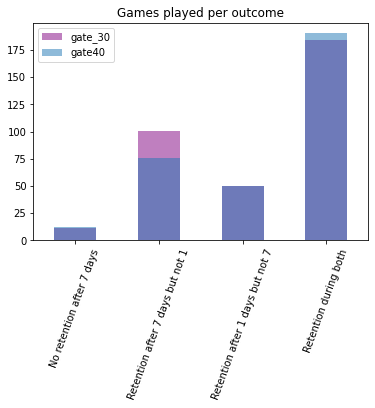

In [12]:
plt.show()

First of all, we see an clear trend that playing many games usually means the users will be retained after 7 days. Playing less than 25 games translates to no retention, whilst playing over 150 indicates strong possibilty of retention.

We also see that the level of retention differs for those that dont return during 1st day but open the app at a later stage. For this group, the average amount of games played is higher than for the group with gate 40. This could possibly be attributed to the fact that the 'Gate_30' group had more plays overall. OR, it could mean that having the Gate EARLIER in the users gametime could lead to an increase in games played! 

## Analysis Part 2 - Correlation

To confirm our intution, we create a quick correlation matrix

In [13]:
#pip install seaborn
import seaborn as sn

We dummify the version and drop the ID

In [14]:
X = data.drop(['userid','version'],axis=1)
X[['gate_30','gate_40']] = pd.get_dummies(data['version'])
X.head(3)

,sum_gamerounds,retention_1,retention_7,gate_30,gate_40
0,3,False,False,1,0
1,38,True,False,1,0
2,165,True,False,0,1


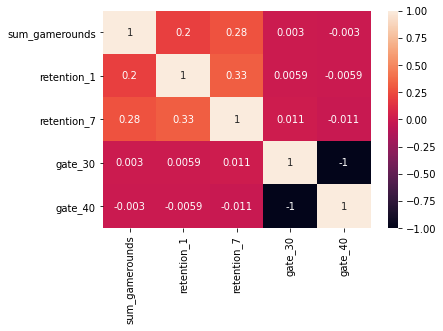

In [15]:
corr =X.corr()
sn.heatmap(corr, annot=True)
plt.show()

The amount of games played correlates higher with 7 day retention than 1 day retention, no surprises there. What is imteresting is the differnce between gate_30 and gate_40's correlation with sum_gamerounds. It seems that having the gate_30 version does increase the number of games played. It also is more likely to retain users both at 1 day and 7 day levels! 

## Analysis Part 3 - Testing Retention rates - Bootstraping

In [16]:
#!pip install statsmodels
from scipy.stats import ttest_1samp
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import norm, zscore

Now that we seem to have a intution on which Gate positioning lead to more gaming, we will test the results with Bootstraping. 

Bootstraping is a technique where data is resampled for an original source to then estimate the distribution of a variable. In this case, we are intrested in the difference in conversion rates for different placements of the paywall-gates.

Our Null-hypothesis, Difference = 0, will then be tested using simulated calculations of the mean of a certain number of samples. But how many? 

Because statistics can be deceiving, we want to do a test that really can differentiate between our conversion rates and not fall for Type-1 or Type-2 errors. Therefore, we shall calculate the Number of observation needed to have a test with STATISTICAL POWER (a measure of the tests validity) of minimum 0.8

In [17]:
Retentions = data.groupby('version')[['retention_1']].mean()
conv_30 = Retentions['retention_1'][0]
conv_40 = Retentions['retention_1'][1]

Bootstraping has the assumption that samples resemble the population they come from. This means that if we randomely select a value from our sample, but it back, and then repeat the process X time, some values can be returened multiple time. This is called Sampling with replacement, or Bootstrapping. We want to simulare the distributions and visually compare the difference.

In [18]:
# We create a list of mean retention rates calculated by the resampled
# datasets
boot_1d = []
for i in range(1,1000):
    # Resample the data (using the orginal datapoints) #
    boot_mean = data.sample(frac=1, replace=True).groupby(by='version')['retention_1'].mean()
    boot_1d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

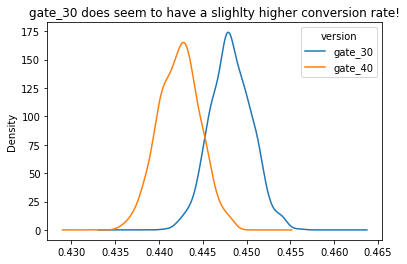

In [19]:
# this gives our sampling distribution
boot_1d.plot.kde()
plt.title('gate_30 does seem to have a slighlty higher conversion rate!')
plt.show()

In [20]:
boot_1d['diff'] = (boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100

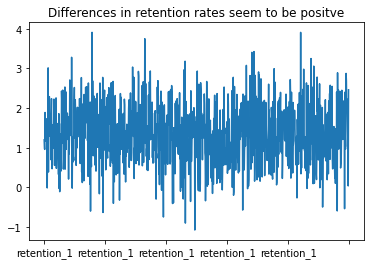

In [21]:
boot_1d['diff'].plot(kind='line')
plt.title('Differences in retention rates seem to be positve')
plt.show()

There seems to be a difference of 0-2.5% between the retention rates. But can we really say that there is a statistically significant difference between the two? 

We set up the null-hypothesis that the difference between means of Gate_30 and Gate_40 is Null. We want to test the 1-sided alternate hypothesis that Gate_30 has a HIGHER retention rate than Gate_40. Also, the minimum testable difference we want to find is 1%.

As previousy mentioned, we will now calculate the minimum sample size or us to be able to statistically certify if there i a difference. We also want statisical power of the test to be at least 0.8.

In [22]:
def get_sample_size(power, p1, p2, cl, max_n=1000000):
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)

        if tmp_power >= power: 
            return n 
        else: 
            n = n + 100

    return "Increase Max N Value"

In [23]:
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    
    qu = stats.norm.ppf(1 - alpha/2)
    
    diff = abs(p2 - p1)
    bp = (p1 + p2) / 2
    
    v1 = p1 * (1 - p1)
    v2 = p2 * (1 - p2)
    
    bv = bp * (1 - bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5)/ (v1 + v2)**0.5)
    
    power = power_part_one + power_part_two
    return(power)

In [53]:
samp = get_sample_size(0.85, conv_30, conv_30*1.01, 0.90)

print('Sample size required to test 1% increase :' ,samp)

Sample size required to test 1% increase : 177201


So we need 177201 observations in both sample to be able to test this 1% difference. Meaning that both groups need around double the amount of users for our test to be valid. By using bootstrapping again, we can simulate new users! 

In [25]:
samp/len(data['userid'])

1.9647739746532282

In [54]:
boot_user = data.sample(frac=1, replace=True)
New1 = boot_user.append(data)
New = pd.DataFrame(New1)
len(New['userid'])


180378

In [40]:
ret_1d_30 = New[New['version']=='gate_30']['retention_1']
ret_1d_40 = New[New['version']=='gate_40']['retention_1']

We perform a Z-test as the usual assumptions are fullfilled

1. Sample greater than 30
2. Independant data points
3. Random selection
4. Equal sample sizes

In [51]:
zscore, pvalue = proportions_ztest([ret_1d_30.sum(),ret_1d_40.sum()],[len(ret_1d_30),len(ret_1d_30)], alternative = 'larger')
print('zscore = {:.3f}, pvalue = {:.3f}'.format(zscore, pvalue))

zscore = 0.304, pvalue = 0.381


As we can see from the p-test, we cannot reject the null hypothesis and conclude that the mean 1-day retention rate of gate_30 is not significantly higher than that of gate_40. Therefore , at 1-day retention levels, it seems that changing the gate doesnt not impact much.